# MCMC fit using mslicer

## version tested on SciServer 2019-01-09 at the AAS

This is my multidimensional Markov Chain Monte Carlo slice sampler, that I wrote on various machines and put on bitbucket for `git` This version seems to work fine with the Julia 0.6 image that is on SciServer as of this date. My Julia code does not seem to be strongly version-depenent **though I do remember some problem with a dot product function..**


In [35]:
#Pkg.add("LinearAlgebra")
#does not work for 0.6, but does not seem to be needed in Julia 0.6. It is needed in
#v 1.0+ or so.

In [4]:
using Plots
#using LinearAlgebra (for v1.0+)
gr(fmt="png") #right now (2018 Oct 21) the SVG backend has nasty resolution issues 
            # with font sizes (too tiny)

INFO: Precompiling module GR.


Plots.GRBackend()

I am going to do David Hogg's exercise with my slice sampler. First I need to get his data in. I need to do a little stuff to make the data into a nice table.

In [5]:
rID = collect(1:20);


I had to do some Vim magic to get all this in the right form for the implied `hvcat` syntax in Julia:

In [6]:
copied_data = [ 
[1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ];
[201 244 47 287 203 58 210 202 198 158 165 201 157 131 166 160 186 125 218 146]; 
[592 401 583 402 495 173 479 504 510 416 393 442 317 311 400 337 423 334 533 344 ];
[61 25 38 15 21 15 27 14 30 16 14 25 52 16 34 31 42 26 16 22];
[9 4 11 7 5 9 4 4 11 7 5 5 5 6 6 5 9 8 6 5];
[-0.84 0.31 0.64 -0.27 -0.33 0.67 -0.02 -0.05 -0.84 -0.69 0.30 -0.46 -0.03 0.50 0.73 -0.52 0.90 0.40 -0.78 -0.56] 
]


6×20 Array{Float64,2}:
   1.0     2.0     3.0     4.0     5.0   …   17.0   18.0   19.0    20.0 
 201.0   244.0    47.0   287.0   203.0      186.0  125.0  218.0   146.0 
 592.0   401.0   583.0   402.0   495.0      423.0  334.0  533.0   344.0 
  61.0    25.0    38.0    15.0    21.0       42.0   26.0   16.0    22.0 
   9.0     4.0    11.0     7.0     5.0        9.0    8.0    6.0     5.0 
  -0.84    0.31    0.64   -0.27   -0.33  …    0.9    0.4   -0.78   -0.56

In [7]:
data = transpose(copied_data) #need to swap rows and columns

20×6 Array{Float64,2}:
  1.0  201.0  592.0  61.0   9.0  -0.84
  2.0  244.0  401.0  25.0   4.0   0.31
  3.0   47.0  583.0  38.0  11.0   0.64
  4.0  287.0  402.0  15.0   7.0  -0.27
  5.0  203.0  495.0  21.0   5.0  -0.33
  6.0   58.0  173.0  15.0   9.0   0.67
  7.0  210.0  479.0  27.0   4.0  -0.02
  8.0  202.0  504.0  14.0   4.0  -0.05
  9.0  198.0  510.0  30.0  11.0  -0.84
 10.0  158.0  416.0  16.0   7.0  -0.69
 11.0  165.0  393.0  14.0   5.0   0.3 
 12.0  201.0  442.0  25.0   5.0  -0.46
 13.0  157.0  317.0  52.0   5.0  -0.03
 14.0  131.0  311.0  16.0   6.0   0.5 
 15.0  166.0  400.0  34.0   6.0   0.73
 16.0  160.0  337.0  31.0   5.0  -0.52
 17.0  186.0  423.0  42.0   9.0   0.9 
 18.0  125.0  334.0  26.0   8.0   0.4 
 19.0  218.0  533.0  16.0   6.0  -0.78
 20.0  146.0  344.0  22.0   5.0  -0.56

In [8]:
x = data[:,2] 
y = data[:, 3]
sig_y = data[:,4]  #scatter in y
sig_x = data[:,5]  #scatter in x
rho_xy = data[:,6];  #covariance
# this names all data nicely

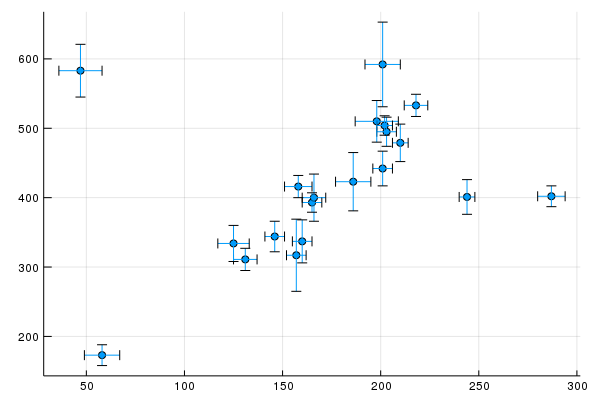

In [9]:
scatter(
    x,y, 
    xerror=sig_x, yerror=sig_y, 
    legend=false
)

In [10]:
# ignore the first four points
good = 5:20
xt = x[good]
yt = y[good]
s_xt = sig_x[good]
s_yt = sig_y[good];

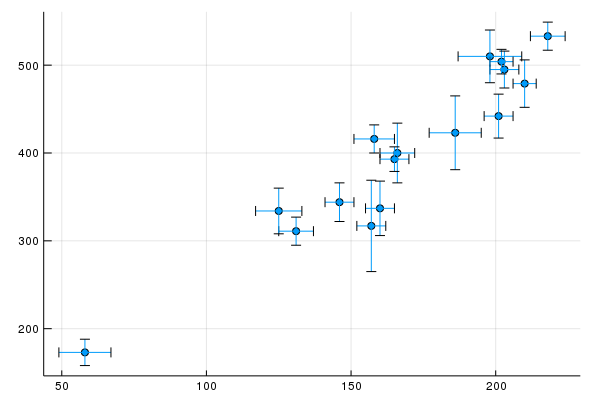

In [11]:
scatter(
    xt,yt, 
    xerror=s_xt, yerror=s_yt, 
    legend=false
)

Ok, **now I have Hogg's data in here in a useful form.**

## Setting up mslicer

In [12]:
function mslicer(g, dim, x0, xargs; N=1000, w=0.5, m=10)
    #=VERSION FOR VECTOR FIXES=#
    #= multi-D slice sampler, g: log of distribution function, 
    dim number of dimensions
    x0: start (or next) point, values of distribution parameters. x1: next point.
    xargs: extra arguments for distribution, Nm samples to return,
        w: "out step" distance, m: max number of outward steps.
    Returns N x dim array.
    Steps successively in each direction in the sample space, so it produces
    dim*N samples as currently written.
    
    Note that you only have to worry about log scaling in 'vertical' comparisons
    in these Monte Carlo chain calculations.
    
    NOTE: this needs to be checked for the whole julia
    vector vs matrix thing: what is  [1 2 3] vs [1,2,3]
    =#
    xs = zeros(N, dim)  # array that will be returned
    xs[1,:] = x0  #x0 should be array 1,dim; needs [1.0 1.0] syntax for this version.
    #print(x0)
    x1 = zeros(1,dim)
    L = zeros(1,dim)
    R = zeros(1,dim)
    way = zeros(1,dim)  # which axis to go along in space
    i = 2    # assumed start values for chain are recorded at xs[1,1]
    while i <= N
        for d in 1:dim       # go one step in each dimensional direction.
            way = 0.0 * way #clear it
            way[d] = 1.0 #set nonzero in direction we go for slicing on this step
            y0 = g(x0,xargs)  #height of distribution at x0
            y = y0 + log(rand()) # height for slice (using log scaled distribution)
            #start stepping out
            U = rand()   # between 0 and 1
            L = x0 - (w * way * U)
            R = L .+ w .* way
            
            V = rand()
            J = floor(m*V)
            K = (m - 1) - J
            while J > 0 && y < g(L,xargs)
                L = L .- w .* way
                J = J - 1
            end
            while K > 0 && y < g(R,xargs)
                R = R .+ w .* way
                K = K - 1
            end
            #now should be stepped out beyond distribution at slice level
            # work back in if no value found:
            Lbar, Rbar = L, R
            while true 
                U = rand()
                x1 = Lbar .+ U .* (Rbar .- Lbar)  # vector subtraction should be correct dir
                if y < g(x1,xargs)
                    break # exit while loop
                end
                if x1[d] < x0[d]
                    Lbar = x1
                    else 
                    Rbar = x1
                end
            end
            xs[i,:] = x1 # found an acceptable point, record in chain (a row)
            x0 = x1 # set initial to new point for next round.
            i += 1
            if i > N
                break # catch case where we reach N in the middle of set of dimensions
            end
        end # for d
        end  #while i
    return xs 
end

mslicer (generic function with 1 method)

In [13]:
# copied in from multid-slicer-mcmc.ipynb
function log_prior(theta)
    alpha, beta, sigma = theta
    if sigma < 0
        return -Inf   # log(0)
    else
        return -0.5 * log(1 + beta^2) - log(sigma)  #Jeffreys prior for slopes
    end
end

log_prior (generic function with 1 method)

In [14]:
# copied in from multid-slicer-mcmc.ipynb
function log_like(theta, xvec)
    alpha, beta, sigma = theta
    x = xvec[1]
    y = xvec[2]
    y_model = alpha .+ beta .* x
    return -0.5 * sum(log(2*pi*sigma^2) .+ (y - y_model).*(y - y_model) / sigma^2)
    #return y - y_model
end

log_like (generic function with 1 method)

In [15]:
function log_posterior(theta, xvec)
    return log_prior(theta) + log_like(theta,xvec)
end

log_posterior (generic function with 1 method)

In [62]:
res = mslicer(log_posterior, 3, [19.0 3.3 17], [xt, yt], N=100000);
# the initial parameters are [intercept, slope, single-sigma-in-y]

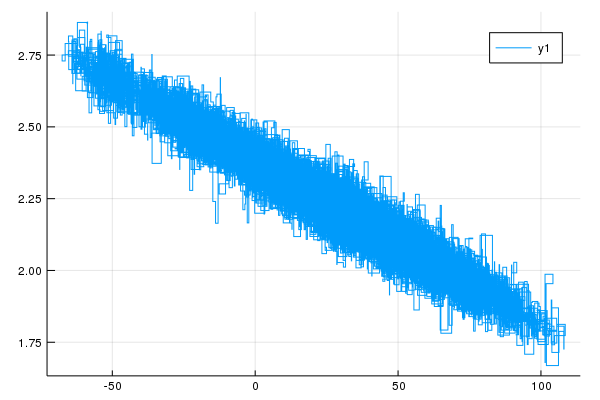

In [63]:
plot(res[10000:end,1], res[10000:end,2])

### Progress

At this point I have done part of Hogg's exercise in "Fitting a model to data," but I have used the prior and posterior models from the `emcee` examples article I read (check the Bayes folder in Drop box for references.) Time for lunch!

In [27]:
size(res)

(100000, 3)

In [64]:
Afit = res[10000:end, 1]
Bfit = res[10000:end, 2];

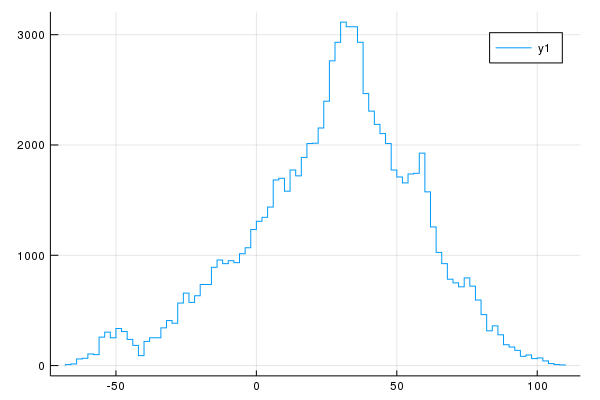

In [65]:
stephist(Afit)

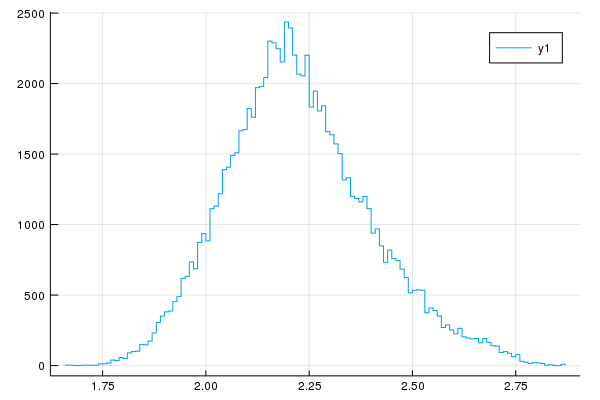

In [66]:
stephist(Bfit)

In [33]:
#This is needed in Julia 1.0+
# using Statistics

In [67]:
Amap = median(Afit)

30.146142705669305

In [68]:
Bmap = median(Bfit)

2.2103040293566174

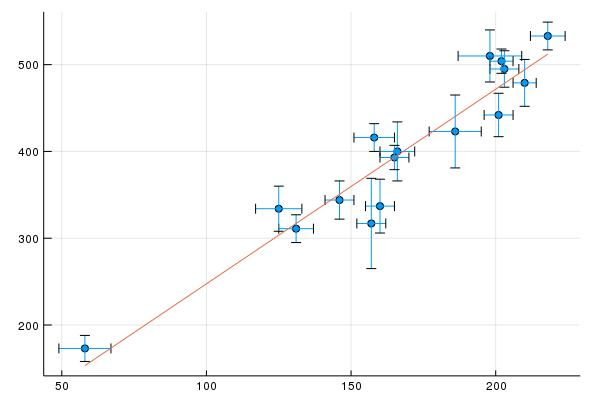

In [61]:
scatter(
    xt,yt, 
    xerror=s_xt, yerror=s_yt, 
    legend=false
)
plot!(xt, Amap .+ Bmap*xt)